# Overview
- This code is part of a project that involves using a machine learning model called BrainBERT to analyze and process neural signals. 
- This notebook is annotated to help someone with minimal background in coding or artificial intelligence understand exactly what is happening at each step.
Detailed explanations are provided in Markdown cells before each code block.


### What BrainBERT is Doing:

BrainBERT is a specialized machine learning model designed to process neural signals recorded through stereo-electroencephalography (sEEG). The primary steps involved in this process are:

1. **Converting Raw sEEG Data into Spectrograms**:
   - **sEEG Data**: These are recordings of electrical activity from electrodes that are placed within the brain.
   - **STFT (Short-Time Fourier Transform)**: This technique is used to convert the raw sEEG data into spectrograms. A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary with time.
   
2. **Passing Spectrogram Images to the Model**:
   - **Spectrograms as Images**: sEEG data is converted into spectrograms. These spectograms are then fed into BrainBERT as images.
   - **Model Processing**: BrainBERT processes these spectrogram images to analyze the neural signals and produce outputs. These outputs can be used for various applications, such as detecting and classifying different types of brain activity.

# Import necessary libraries

In this section, we import the libraries we need for this project. Libraries are collections of code that others have written to make it easier to perform certain tasks.

- `os` and `sys`: These libraries help with file and system operations.
- `models`: This is a custom library for handling machine learning models.
- `OmegaConf`: A library for managing configurations easily.
- `numpy`: A library for numerical operations, like handling large lists of numbers.
- `matplotlib.pyplot`: A library for creating plots and graphs.
- `scipy`: A library for scientific and technical computing, including signal processing and statistics.
- `torch`: A library for machine learning, specifically for creating and using neural networks.


In [1]:
!pip install omegaconf

In [2]:
import os
#Path to dir on my Macbook
#os.chdir('/Users/vineetreddy/Library/CloudStorage/Dropbox/CZW_MIT/BrainBERT')  # Change to the BrainBERT directory
#Path to dir on Linux Computer
os.chdir('/home/vineetreddy/Dropbox/CZW_MIT/BrainBERT')  # Change to the BrainBERT directory
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path) # Add the parent directory to the system path
import models # Import custom models (user-defined)
from omegaconf import OmegaConf # Library for managing configurations
import numpy as np # Library for numerical operations
import matplotlib.pyplot as plt # Library for plotting graphs
from scipy import signal, stats # Libraries for signal processing and statistical functions
import torch # PyTorch library for machine learning

# Define a function to plot time series data

Here we define a function called `plot_time_series`. A function is a reusable block of code that performs a specific task. This function creates a visual plot of the data showing how voltage changes over time.

- `plt.figure(figsize=(10, 3))`: This sets the size of the plot.
- `plt.xticks(fontsize=20)`: This sets the font size of the x-axis labels.
- `plt.yticks(fontsize=20)`: This sets the font size of the y-axis labels.
- `plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)`: This labels the y-axis (vertical) as "Voltage" with units in microvolts.
- `plt.xlabel("Time (s)", fontsize=25)`: This labels the x-axis (horizontal) as "Time" in seconds.
- `plt.plot(wav)`: This plots the waveform data (voltage over time).

- note: **ask about "what is this doing"!! - vineet**


In [3]:
def plot_time_series(path):
    plt.figure(figsize=(10,3)) # Set the figure size
    plt.xticks(fontsize=20) # Set the font size of x-ticks
    plt.yticks(fontsize=20) # Set the font size of y-ticks
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25) # Label the y-axis with "Voltage (µV)"
    plt.xticks(np.arange(0,len(wav)+1, 2048), [x/2048 for x in np.arange(0,len(wav)+1, 2048)]) #what is this doing?
    plt.xlabel("Time (s)", fontsize=25) # Label the x-axis with "Time (s)"
    plt.plot(wav) # Plot the waveform data

# Load a waveform file (example data) and call the function to plot the waveform

We load a sample data file called `example_wav_1.npy`, which contains the waveform data. Then we call the `plot_time_series` function to create a plot of this data.

- `wav = np.load("example_wav_1.npy")`: This loads the data from a file. You can replace this with your numpy file.
- `plot_time_series(wav)`: This calls the function to plot the data.


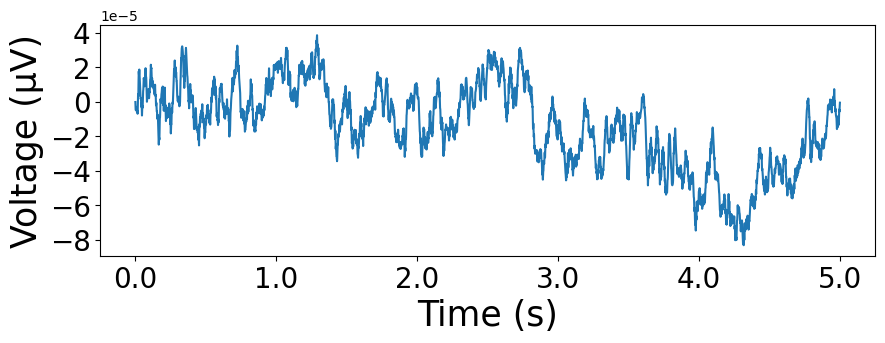

In [4]:
#Example File
#wav = np.load("example_wav_1.npy")

#Numpy File on Macbook
#wav = np.load("/Users/vineetreddy/Library/CloudStorage/Dropbox/CZW_MIT/sub-HUP060_ses-presurgery_task-ictal_acq-seeg_run-01_ieeg_LAF1_epoch1.npy")
#Numpy File on Linux Computer
wav = np.load("/home/vineetreddy/Dropbox/CZW_MIT/sub-HUP060_ses-presurgery_task-ictal_acq-seeg_run-01_ieeg_LAF1_epoch1.npy")
plot_time_series(wav)

# Define a function to compute the Short-Time Fourier Transform (STFT) of a signal

The STFT (short-time Fourier transform) is a mathematical technique used to analyze the frequency content of a signal over time. This is useful for understanding how the frequencies in a signal change.

- `signal.stft`: This function computes the STFT.
- `np.abs`: This computes the absolute value, which gives us the magnitude of the frequencies.
- `stats.zscore`: This normalizes the data using z-score normalization, which helps in comparing different signals.
- The function handles different types of normalization and returns the frequency, time, and transformed data.

Boundary effects: When performing the STFT, the edges of the signal might have some artifacts. We handle this by clipping the data.


In [5]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs) # Compute STFT
    Zxx = Zxx[:clip_fs] # Clip the frequency components if needed
    f = f[:clip_fs]

    Zxx = np.abs(Zxx) # Take the absolute value (magnitude)
    clip = 5 #To handle boundary effects
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1) # Normalize using z-score
        t = t[clip:-clip]
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip]) # Apply baseline normalization
        t = t[clip:-clip]
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip]) # Convert to decibels
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace() # Debugging tool if there are NaN values

    return f, t, Zxx # Return frequency, time, and transformed data


# Define a function to plot the STFT of the signal

This function plots the STFT, showing how the frequency content of the signal changes over time.

- `plt.pcolormesh`: This creates a color plot, where colors represent the magnitude of frequencies.
- `plt.colorbar`: This adds a color bar to the plot, which shows the scale of magnitudes.
- The plot has labels and custom font sizes for readability.

- note: **TODO hardcode sampling rate**

In [6]:
def plot_stft(path, clip_fs=40):
    wav = np.load(path) # Load the waveform data
    f,t,linear = get_stft(wav, 2048, clip_fs=clip_fs, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) # Compute STFT (TODO hardcode sampling rate)
    plt.figure(figsize=(15,3)) # Set figure size

    g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5) # Create a pseudocolor plot

    cbar = plt.colorbar(g1) # Add a colorbar
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size) # Set colorbar tick font size
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15) # Label colorbar
    plt.xticks(fontsize=20) # Set x-tick font size
    plt.ylabel("")
    plt.yticks(fontsize=20) # Set y-tick font size
    plt.xlabel("Time (s)", fontsize=20) # Label x-axis
    plt.ylabel("Frequency (Hz)", fontsize=20) # Label y-axis

# Call the function to plot the STFT of the example waveform data

Here we call the `plot_stft` function to create a plot showing how the frequencies in the example waveform data change over time.

- `clip_fs=25`: This limits the number of frequency components to show.


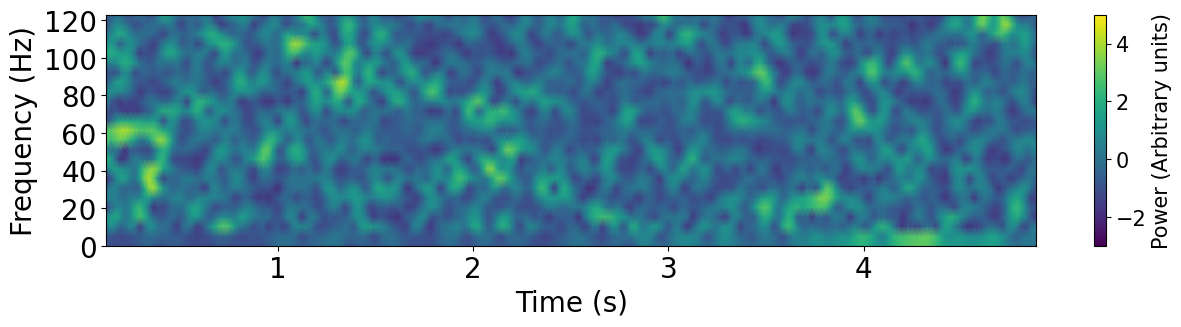

In [7]:
#Example File
#plot_stft("example_wav_1.npy", clip_fs=25)
#MacBook Path
#plot_stft("/Users/vineetreddy/Library/CloudStorage/Dropbox/CZW_MIT/sub-HUP060_ses-presurgery_task-ictal_acq-seeg_run-01_ieeg_LAF1_epoch1.npy", clip_fs=25)
#Linux Computer Path
plot_stft("/home/vineetreddy/Dropbox/CZW_MIT/sub-HUP060_ses-presurgery_task-ictal_acq-seeg_run-01_ieeg_LAF1_epoch1.npy", clip_fs=25)

# Define a function to build a model

In machine learning, we use models to learn from data and make predictions. This function builds a model using a configuration file that specifies the details of the model.

- `torch.load`: This loads a saved model from a file.
- `models.build_model`: This is a custom function that creates a model using the configuration.

In [8]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt # Path to model checkpoint
    init_state = torch.load(ckpt_path) # Load model checkpoint
    upstream_cfg = init_state["model_cfg"] # Extract model configuration
    upstream = models.build_model(upstream_cfg) # Build the model using the configuration
    return upstream # Return the model

# Define a function to load model weights

Models need to be trained on data to learn. This function loads the learned weights (parameters) into the model.

- `model.load_weights`: This is a custom function to load the weights into the model.
- `multi_gpu`: If using multiple GPUs (powerful processors for training models), load the weights accordingly.


In [9]:
def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states) # Load weights for multi-GPU setup
    else:
        model.load_weights(states) # Load weights for single-GPU setup

# Specify the path to the model checkpoint and create a configuration object with the checkpoint path

**Note: Replace ckpt_path with the path on your computer to the pre-trained weights for the model.**

We need to specify where the pre-trained model weights are stored and create a configuration object that holds this information.

- `OmegaConf.create`: This creates a configuration object.

In [10]:
# ckpt_path = "/storage/czw/self_supervised_seeg/pretrained_weights/stft_large_pretrained.pth"
#Macbook Path
#ckpt_path = "/Users/vineetreddy/Library/CloudStorage/Dropbox/CZW_MIT/stft_large_pretrained_256hz.pth" # path to pre-trained weights for model
#Linux Computer Path
ckpt_path = "/home/vineetreddy/Dropbox/CZW_MIT/stft_large_pretrained_256hz.pth" # path to pre-trained weights for model
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})

# Build and initialize the model

Now we build the model using the configuration and move it to the GPU for faster computations.

- `model.to('cuda')`: Moves the model to the GPU.
- `load_model_weights`: Loads the pre-trained weights into the model.

In [11]:
model = build_model(cfg)
model.to('cuda') # Move the model to GPU
init_state = torch.load(ckpt_path) # Load the initial state of the model
load_model_weights(model, init_state['model'], False) # Load the model weights

/home/vineetreddy/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Compute the STFT of the waveform data and prepare the inputs for the model

We need to transform the waveform data into a format suitable for the model. This involves computing the STFT and converting the data to a tensor (a multi-dimensional array).

- `torch.FloatTensor`: Converts the data to a tensor.
- `unsqueeze(0)`: Adds an extra dimension to the tensor.
- `transpose(1, 2)`: Changes the order of dimensions in the tensor.
- `mask`: A mask used in the model to indicate which parts of the data to ignore.

- note: **"vineet change 2048 below to 256"**
- note: **"TODO hardcode sampling rate"**

In [12]:
f,t,linear = get_stft(wav, 2048, clip_fs=25, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda') # Create a mask

# Get the model output without gradient computation and check the shapes of the inputs and the output

We pass the prepared data to the model to get the output. `torch.no_grad` ensures that we do not compute gradients, which saves memory and computation time during inference (prediction).

- `model.forward`: Runs the data through the model to get predictions.
- `inputs.shape, out.shape`: Checks the shapes of the input and output data to ensure they are correct.


In [13]:
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)
inputs.shape, out.shape

(torch.Size([1, 196, 25]), torch.Size([1, 196, 768]))